In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
image_dir = Path('drive/MyDrive/data')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [ ]:
print(filepaths[0:5])

[PosixPath('drive/MyDrive/data/without_mask/104.jpg'), PosixPath('drive/MyDrive/data/without_mask/120.jpg'), PosixPath('drive/MyDrive/data/without_mask/122.jpg'), PosixPath('drive/MyDrive/data/without_mask/1.jpg'), PosixPath('drive/MyDrive/data/without_mask/100.jpg')]


In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [ ]:
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(3)

,Filepath,Label
0,drive/MyDrive/data/with_mask/382-with-mask.jpg,with_mask
1,drive/MyDrive/data/with_mask/316-with-mask.jpg,with_mask
2,drive/MyDrive/data/without_mask/412.jpg,without_mask


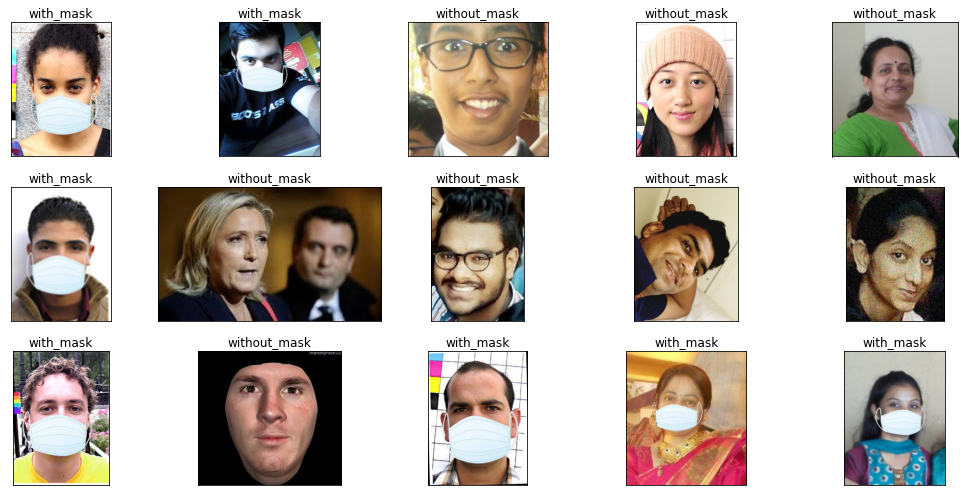

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 991 validated image filenames belonging to 2 classes.
Found 247 validated image filenames belonging to 2 classes.
Found 138 validated image filenames belonging to 2 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
31/31 [==============================] - 579s 19s/step - loss: 0.2935 - binary_accuracy: 0.8560 - val_loss: 0.0160 - val_binary_accuracy: 0.9960
Epoch 2/10
31/31 [==============================] - 47s 2s/step - loss: 0.0167 - binary_accuracy: 0.9936 - val_loss: 0.0043 - val_binary_accuracy: 1.0000
Epoch 3/10
31/31 [==============================] - 47s 2s/step - loss: 0.0149 - binary_accuracy: 0.9944 - val_loss: 0.0089 - val_binary_accuracy: 0.9960
Epoch 4/10
31/31 [==============================] - 47s 2s/step - loss: 0.0018 - binary_accuracy: 0.9996 - val_loss: 0.0375 - val_binary_accuracy: 0.9960


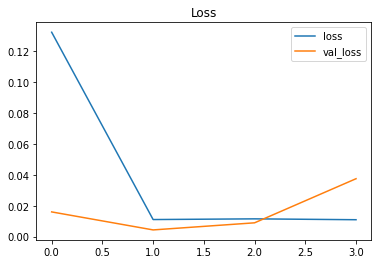

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00255
Test Accuracy: 100.00%


In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

In [ ]:
Predict_Label = (test_images.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())

In [ ]:
pred = [Predict_Label[k] for k in pred]

In [ ]:
print(pred[:10])

['with_mask', 'without_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask']


In [ ]:
model.save("model", save_format="h5")